# Notebook 04: Inventory Optimization Analysis

**Project:** Retail Demand Forecasting & Inventory Optimization for Walmart

## 1. Business Context

In the previous notebook, we successfully developed a LightGBM model that can forecast weekly sales with a high degree of accuracy (8.19% WMAPE). This notebook bridges the gap between the forecast and actionable business decisions.

Our goal is to use these demand forecasts to simulate an inventory policy. We will calculate two fundamental inventory parameters for each store-department:
1.  **Safety Stock:** The extra inventory held to mitigate the risk of stockouts caused by demand uncertainty and forecast errors.
2.  **Reorder Point (ROP):** The inventory level that triggers a new order from the supplier.

By calculating these parameters in a data-driven way, we can demonstrate how Walmart can maintain a high service level (e.g., 95% probability of not stocking out) while minimizing holding costs from excess inventory.

## 2. Objectives

*   Load our trained forecasting model and generate predictions for the validation dataset.
*   Clearly define the assumptions for our inventory simulation (service level, lead time).
*   Calculate the forecast error (demand uncertainty) for each item.
*   Implement the formulas for Safety Stock and Reorder Point.
*   Analyze the results to show how inventory policy would change based on item characteristics.
*   Translate the analytical results into a clear business recommendation.

In [1]:
# Core data science libraries
import pandas as pd
import numpy as np
import joblib

# Statistical libraries
from scipy.stats import norm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# --- Load Assets ---
# Load the feature-engineered dataset
try:
    df = pd.read_parquet('../data/walmart_sales_data_feature_engineered.parquet')
except Exception as e:
    df = pd.read_csv('../data/walmart_sales_data_feature_engineered.csv')

# Load the trained LightGBM model
try:
    model = joblib.load('../models/lgb_demand_forecasting_model.pkl')
except FileNotFoundError:
    print("Model file not found. Please run Notebook 03 to train and save the model first.")


# Convert 'Date' back to datetime and prepare data
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

print("Assets loaded successfully.")

Assets loaded successfully.


## 3. Generate Forecasts for Simulation

First, we need the inputs for our simulation. We'll replicate the time-based split from the previous notebook to get our validation set. Then, we'll use our loaded model to generate predictions. This gives us a side-by-side view of `actual_sales` and `predicted_sales`, which is the foundation of our analysis.

In [2]:
# Re-create the time-based split to get the validation set
features = [
    'Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Year', 'Month', 'WeekOfYear',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'Weekly_Sales_Lag_52', 'Weekly_Sales_Lag_1', 'Weekly_Sales_4_Week_Mean'
]
target = 'Weekly_Sales'

# Convert categorical features for the model
for col in ['Store', 'Dept', 'Type', 'IsHoliday']:
    df[col] = df[col].astype('category')

validation_cutoff_date = df['Date'].max() - pd.DateOffset(months=6)
val_df = df[df['Date'] >= validation_cutoff_date].copy()

X_val = val_df[features]
y_val = val_df[target]

# Generate predictions
val_df['predicted_sales'] = model.predict(X_val)

# For inventory calculations, it doesn't make sense to have negative demand.
# We'll set a floor of 0 for predicted sales.
val_df['predicted_sales'] = np.maximum(0, val_df['predicted_sales'])


# Create our primary results DataFrame for the simulation
results_df = val_df[['Date', 'Store', 'Dept', 'Weekly_Sales', 'predicted_sales']].copy()
results_df.rename(columns={'Weekly_Sales': 'actual_sales'}, inplace=True)

print("Forecasts generated for the validation period.")
results_df.head()

Forecasts generated for the validation period.


,Date,Store,Dept,actual_sales,predicted_sales
64,2012-04-27,1,1,16347.60,28375.982584
65,2012-05-04,1,1,17147.44,20972.473416
66,2012-05-11,1,1,18164.20,19733.546003
67,2012-05-18,1,1,18517.79,16946.155720
68,2012-05-25,1,1,16963.55,18026.183760


## 4. Inventory Optimization Simulation

Now we will use the forecasts to calculate our inventory parameters. This requires us to make a few key business assumptions, which we must state clearly. In a real-world project, these values would be provided by the supply chain or operations team.

### 4.1 Business Assumptions

*   **Service Level:** We are targeting a **95% service level**. This means we want to have enough stock on hand to meet customer demand 95% of the time, accepting a 5% risk of stocking out. This is a common target for many retail products.
*   **Supplier Lead Time:** We will assume a **14-day (2-week)** lead time. This is the time that elapses between placing an order with a supplier and the inventory arriving at the store.

### 4.2 Key Calculation: Demand Uncertainty

The most important input for safety stock is **demand uncertainty**, which we define as the **standard deviation of our forecast error**. A product whose sales are highly variable and hard to predict will need more safety stock than a product with very stable, predictable sales.

In [5]:
# --- Step 1: Define Assumptions ---
SERVICE_LEVEL = 0.95
LEAD_TIME_WEEKS = 2

# The Z-score tells us how many standard deviations we need to be above the mean to hit our service level.
Z_SCORE = norm.ppf(SERVICE_LEVEL)
print(f"Z-score for {SERVICE_LEVEL:.0%} service level: {Z_SCORE:.2f}")


# --- Step 2: Calculate Forecast Error for Each Item ---
results_df['forecast_error'] = results_df['actual_sales'] - results_df['predicted_sales']

# Calculate the standard deviation of the error for each store-department combination
# This is our measure of demand uncertainty/volatility
demand_uncertainty = results_df.groupby(['Store', 'Dept'], observed=True)['forecast_error'].std().reset_index()

# **FIX 1: Use direct assignment for rename instead of inplace=True**
demand_uncertainty = demand_uncertainty.rename(columns={'forecast_error': 'forecast_error_std'})

# (Optional Debugging) You can uncomment the line below to see the column names and confirm the fix
# print("Columns in demand_uncertainty DataFrame:", demand_uncertainty.columns)

# Merge this back into our main results dataframe
results_df = pd.merge(results_df, demand_uncertainty, on=['Store', 'Dept'], how='left')

# **FIX 2: Use direct assignment for fillna instead of inplace=True**
median_std = results_df['forecast_error_std'].median()
results_df['forecast_error_std'] = results_df['forecast_error_std'].fillna(median_std)


# --- Step 3: Calculate Safety Stock and Reorder Point ---
# Safety Stock Formula = Z-score * Standard Deviation of Forecast Error * sqrt(Lead Time)
results_df['safety_stock'] = Z_SCORE * results_df['forecast_error_std'] * np.sqrt(LEAD_TIME_WEEKS)

# Reorder Point Formula = (Forecasted Demand during Lead Time) + Safety Stock
results_df['reorder_point'] = (results_df['predicted_sales'] * LEAD_TIME_WEEKS) + results_df['safety_stock']

# We can't have negative inventory, so set a floor of 0
results_df['safety_stock'] = np.maximum(0, results_df['safety_stock'])
results_df['reorder_point'] = np.maximum(0, results_df['reorder_point'])


print("\n--- Results with Inventory Parameters ---")
# Show a sample of the final results, focusing on the new columns
results_df[['Store', 'Dept', 'actual_sales', 'predicted_sales', 'safety_stock', 'reorder_point']].head(10)

Z-score for 95% service level: 1.64

--- Results with Inventory Parameters ---


,Store,Dept,actual_sales,predicted_sales,safety_stock,reorder_point
0,1,1,16347.60,28375.982584,5817.024927,62568.990096
1,1,1,17147.44,20972.473416,5817.024927,47761.971759
2,1,1,18164.20,19733.546003,5817.024927,45284.116933
3,1,1,18517.79,16946.155720,5817.024927,39709.336367
4,1,1,16963.55,18026.183760,5817.024927,41869.392447
5,1,1,16065.49,17882.857684,5817.024927,41582.740295
6,1,1,17666.00,17445.012446,5817.024927,40707.049819
7,1,1,17558.82,16710.413142,5817.024927,39237.851211
8,1,1,16633.41,17968.391675,5817.024927,41753.808278
9,1,1,15722.82,16368.934366,5817.024927,38554.893658


## 5. Analysis and Business Insights

We have successfully translated our ML forecast into tangible inventory policy recommendations.

### 5.1 Key Insight: Volatility Drives Safety Stock

Let's visualize the relationship between an item's average weekly sales and the amount of safety stock it requires. We would expect that items with higher volatility (and thus higher forecast error) require more safety stock, regardless of their sales volume.

C:\Users\Dylan\AppData\Local\Temp\ipykernel_9224\2881436655.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df = results_df.groupby(['Store', 'Dept']).agg({


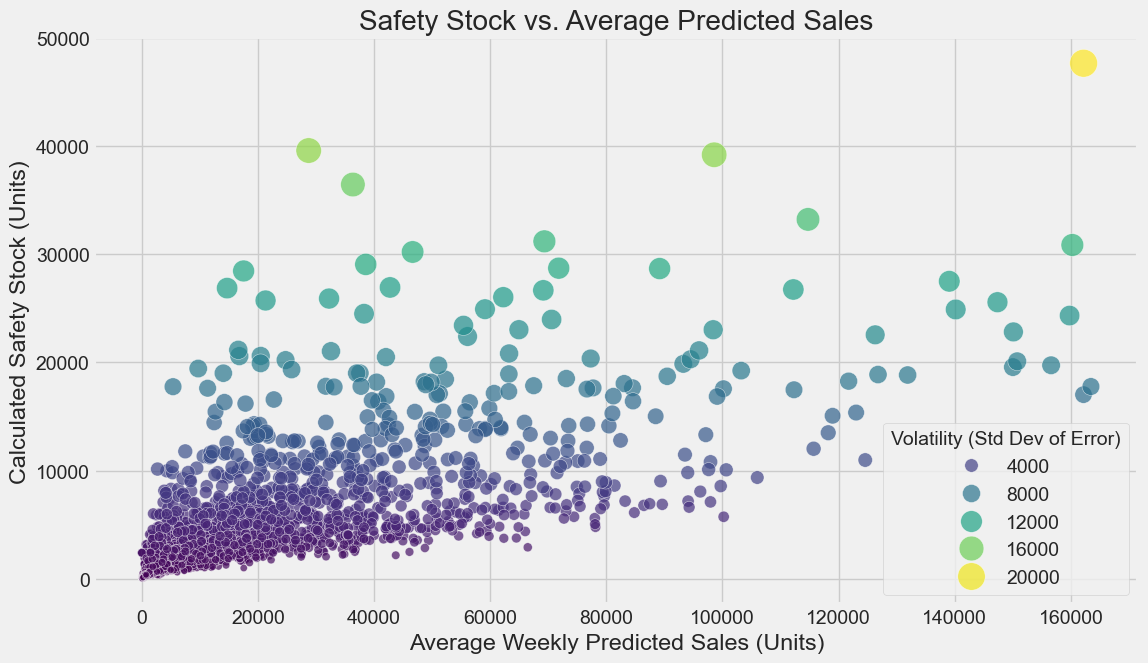

In [6]:
# Aggregate results to the store-dept level for a clearer plot
analysis_df = results_df.groupby(['Store', 'Dept']).agg({
    'predicted_sales': 'mean',
    'forecast_error_std': 'mean', # This is our proxy for volatility
    'safety_stock': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=analysis_df,
    x='predicted_sales',
    y='safety_stock',
    size='forecast_error_std', # Point size represents volatility
    hue='forecast_error_std',  # Color represents volatility
    palette='viridis',
    sizes=(20, 400),
    alpha=0.7
)
plt.title('Safety Stock vs. Average Predicted Sales')
plt.xlabel('Average Weekly Predicted Sales (Units)')
plt.ylabel('Calculated Safety Stock (Units)')
plt.legend(title='Volatility (Std Dev of Error)')
plt.show()

**Insight from the Plot:**
The visualization clearly shows that safety stock is not just a function of sales volume. We can see items with similar average sales that require vastly different levels of safety stock. The larger, brighter-colored points represent items with high volatility (`forecast_error_std`). These items require significantly more safety stock to maintain our 95% service level, even if their average sales aren't the highest.

**This is the core value proposition of our project.** Instead of using a naive rule like "keep 2 weeks of inventory for everything," our data-driven approach allows a planner to:
1.  **Allocate Capital Intelligently:** Invest more safety stock in volatile, unpredictable products where the risk of stockout is highest.
2.  **Reduce Excess Inventory:** Hold less safety stock for stable, predictable products, freeing up cash and warehouse space.

## 6. Project Conclusion and Next Steps

Across these four notebooks, we have completed an end-to-end data science project. We began with raw data, performed exploratory analysis, engineered relevant features, built a high-performing forecasting model, and finally, translated that model's output into a concrete and value-driving inventory optimization strategy.

**Next Steps for Deployment:**
*   **Dashboard Development:** The `results_df` would be the foundation for an interactive dashboard (in Tableau, Power BI, or Plotly) for supply chain planners.
*   **Cost Simulation:** By adding assumed unit costs and holding costs, we could quantify the financial benefit (e.g., "Reduce holding costs by $X million while protecting $Y million in sales from stockouts").
*   **Production Pipeline:** The entire process could be automated and integrated with Walmart's ERP system to provide dynamic, weekly updates to inventory parameters.

### Quantifying the Financial Impact

While our simulation demonstrates the *methodology* for optimizing inventory, the final step in a business setting would be to quantify the expected Return on Investment (ROI). To do this, we would require two key financial metrics from the business:

1.  **Inventory Holding Cost:** The cost of holding inventory for a year, typically expressed as a percentage of the inventory's value (e.g., 20-30%). This includes warehousing, insurance, labor, and capital costs.
2.  **Product Gross Margin:** The profit made on a product, which allows us to calculate the cost of a lost sale (stockout).

**Hypothetical Example:** Assume a 25% annual holding cost and a 40% average gross margin. By implementing our data-driven safety stock policy, we might find we can reduce inventory on stable, high-volume products by 10% while increasing it on volatile products. This re-allocation could lead to a net **reduction of millions of dollars in holding costs** while simultaneously **protecting sales revenue** by reducing stockouts on unpredictable items.

### Future Improvements: Advanced Distributional Analysis

Our simulation assumes that the forecast errors follow a Normal (Gaussian) distribution when calculating the Z-score for our service level. While this is a common and robust starting point, a more advanced implementation would validate this assumption.

A deeper analysis would involve fitting different statistical distributions to the forecast errors for different product categories. For example:
*   **Poisson Distribution:** For very low-volume, slow-selling items where sales are discrete counts.
*   **Negative Binomial Distribution:** For items with high variance (i.e., the variance is much larger than the mean sales).

Using the correct underlying distribution for different product types would allow for an even more precise calculation of safety stock, further optimizing the balance between inventory cost and service level.